In [1]:
# install yahoo finance and other modules if not installed before
#%pip install yfinance
#%pip install matplotlib
#%pip install torch

import yfinance as yf  
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from pandas.tseries.offsets import DateOffset

[*********************100%***********************]  2 of 2 completed


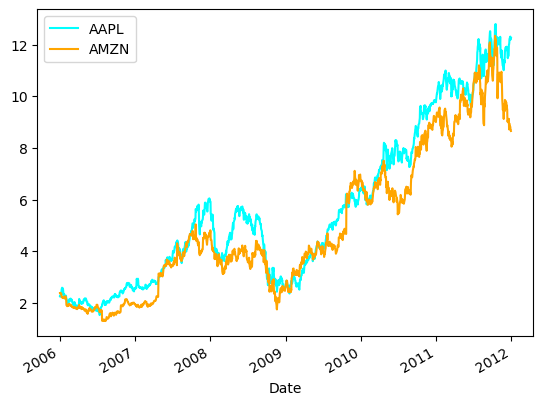

In [2]:
# Get the stock data specifying the stock ticker, start date, and end date
startDate = '2006-01-01'
endDate = '2012-01-01'
data = yf.download(['AMZN', 'AAPL'], startDate, endDate)

# Plot the adjusted close prices
prices = data["Adj Close"]
ax = prices.plot.line(color={'AAPL': 'cyan', 'AMZN': 'orange'})

# Seperate stock data
amazon = prices["AMZN"]
apple = prices["AAPL"]

[*********************100%***********************]  1 of 1 completed


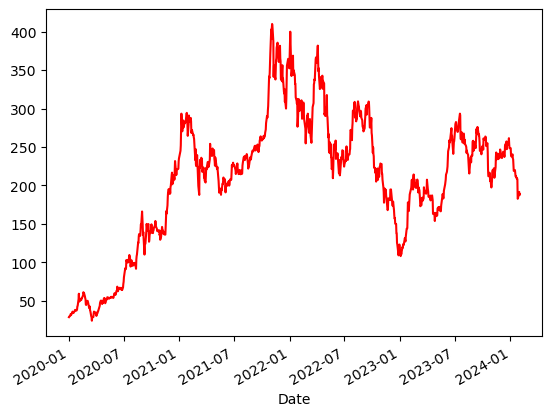

In [3]:
# Get the stock data specifying the stock ticker, start date, and end date
tstartDate = '2020-01-01'
tendDate = datetime.today().strftime('%Y-%m-%d')
data = yf.download(['TSLA'], tstartDate, tendDate)

# Plot the adjusted close prices
tesla = data["Adj Close"]
ax = tesla.plot.line(color='red')

In [4]:
# Amazon: Offset back in X years and T times magnified
offsetByYears = 15
magnifyBy = 67
if magnifyBy == 1:
    amazonModName = "AMZN, " + str(offsetByYears) + " years backshift"
else:
    amazonModName = "AMZN, x" + str(magnifyBy) + " value and " + str(offsetByYears) + " years backshift"
amazonMod = pd.Series(data = amazon.values * magnifyBy, index = amazon.index + DateOffset(years=offsetByYears), name = amazonModName)

# Apple: Offset back in X years and T times magnified
offsetByYears = 15
magnifyBy = 67
if magnifyBy == 1:
    appleModName = "AAPL, " + str(offsetByYears) + " years backshift"
else:
    appleModName = "AAPL, x" + str(magnifyBy) + " value and " + str(offsetByYears) + " years backshift"
appleMod = pd.Series(data = apple.values * magnifyBy, index = apple.index + DateOffset(years=offsetByYears), name = appleModName)

# Tesla: Current value and T times
tesla.name = "TSLA, current value"
magnifyBy = 1
if magnifyBy < 1:
    teslaModName = "TSLA, 1/" + str(1/magnifyBy) + " value"
else:
    teslaModName = "TSLA, x" + str(magnifyBy) + " value"
teslaMod = pd.Series(data = tesla.values * magnifyBy, index = tesla.index, name = teslaModName)



Mac Silicon GPU
Epoch 500/50000, Loss = 0.2077
Epoch 1000/50000, Loss = 0.2044
Epoch 1500/50000, Loss = 0.2029
Epoch 2000/50000, Loss = 0.2019
Epoch 2500/50000, Loss = 0.2010
Epoch 3000/50000, Loss = 0.2003
Epoch 3500/50000, Loss = 0.1996
Epoch 4000/50000, Loss = 0.1990
Epoch 4500/50000, Loss = 0.1985
Epoch 5000/50000, Loss = 0.1980
Epoch 5500/50000, Loss = 0.1975
Epoch 6000/50000, Loss = 0.1970
Epoch 6500/50000, Loss = 0.1966
Epoch 7000/50000, Loss = 0.1962
Epoch 7500/50000, Loss = 0.1958
Epoch 8000/50000, Loss = 0.1955
Epoch 8500/50000, Loss = 0.1951
Epoch 9000/50000, Loss = 0.1948
Epoch 9500/50000, Loss = 0.1945
Epoch 10000/50000, Loss = 0.1942
Epoch 10500/50000, Loss = 0.1939
Epoch 11000/50000, Loss = 0.1936
Epoch 11500/50000, Loss = 0.1934
Epoch 12000/50000, Loss = 0.1931
Epoch 12500/50000, Loss = 0.1929
Epoch 13000/50000, Loss = 0.1926
Epoch 13500/50000, Loss = 0.1924
Epoch 14000/50000, Loss = 0.1922
Epoch 14500/50000, Loss = 0.1920
Epoch 15000/50000, Loss = 0.1918
Epoch 15500/50

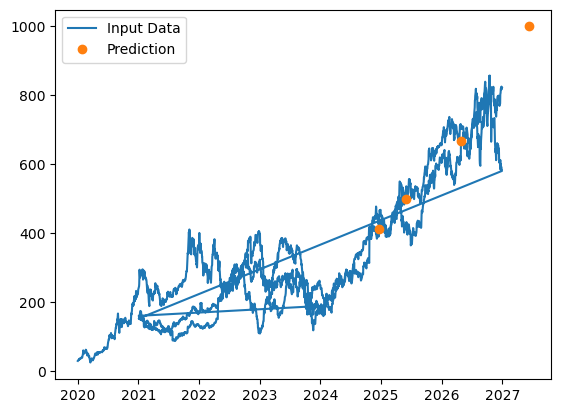

In [5]:
# train NN with all this data, and predict dates for a set of price targets (Xtargets below)

# import necessary libraries
import torch
import numpy as np

# Set device for GPU acceleration if available
# cuda (pc-gpu) or mps (apple-silicon)
import platform
sys = platform.system()
if sys == 'Windows' or sys == 'Linux':
    if torch.cuda.is_available(): 
        device = 'cuda' 
        print(torch.cuda.get_device_properties(0)) 
elif sys == 'Darwin':
    if torch.backends.mps.is_available(): 
        device = 'mps' 
        print("Mac Silicon GPU") 
else:
    device = 'cpu'

# set random seed for reproducibility
torch.manual_seed(0)

# prepare the data
Xdata = tesla.values.astype(float).tolist()
Xmax = max(Xdata)
Xdata += amazonMod.values.astype(float).tolist()
Xdata += appleMod.values.astype(float).tolist()
Ydata = tesla.index.astype(int).astype(float).tolist()
Ydata += amazonMod.index.astype(int).astype(float).tolist()
Ydata += appleMod.index.astype(int).astype(float).tolist()
Xtargets = [Xmax, 499.0, 666.0, 999.0]

X = torch.tensor(Xdata).to(device).unsqueeze(-1)
Y = torch.tensor(Ydata).to(device).unsqueeze(-1)
X_t = np.array(Xtargets)

# normalize the data
X_mean, X_std = X.mean(), X.std()
Y_mean, Y_std = Y.mean(), Y.std()
X_norm = (X - X_mean) / X_std
Y_norm = (Y - Y_mean) / Y_std

# define the model
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size).to(device)
        self.fc2 = torch.nn.Linear(hidden_size, output_size).to(device)
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.nn.functional.relu(x).to(device)
        x = self.fc2(x)
        return x

model = MLP(1, 1000, 1).to(device)

# define the loss function and the optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005) #normalization allows use of standard lr for all data ranges

# Set the number of epochs
num_epochs = 50000

for epoch in range(num_epochs):
    # forward pass
    Y_pred = model(X_norm)# calculate the loss
    loss = loss_fn(Y_pred, Y_norm)

    # zero the gradients
    optimizer.zero_grad()

    # backpropagate the loss
    loss.backward()

    # update the weights and biases
    optimizer.step()
    
    # Print progress
    if (epoch + 1) % 500 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss = {loss.item():.4f}')

# Test the model
X_test = torch.tensor(X_t, dtype=torch.float).to(device).view(-1, 1)
X_test_norm = (X_test - X_mean) / X_std
y_pred = model(X_test_norm) * Y_std + Y_mean
print(y_pred)

# Graphing of results
import matplotlib.pyplot as plt

# Normal graphing for world population data
#plt.plot(X.numpy(), Y.numpy(), label='Input Data')
#plt.plot(X_test.numpy(), y_pred.detach().numpy(), 'o', label='Prediction')

# Format dates
Ynp = Y.cpu().numpy().astype(float)
Yflt = np.ndarray.flatten(Ynp).tolist()
Ydata_plot = pd.to_datetime(Yflt)

Yp_np = y_pred.cpu().detach().numpy().astype(float)
Yp_flt = np.ndarray.flatten(Yp_np).tolist()
Yp_data_plot = pd.to_datetime(Yp_flt)

# Invert graphing
plt.plot(Ydata_plot, X.cpu().numpy(), label='Input Data')
plt.plot(Yp_data_plot, X_test.cpu().numpy(), 'o', label='Prediction')

plt.legend()
plt.show()

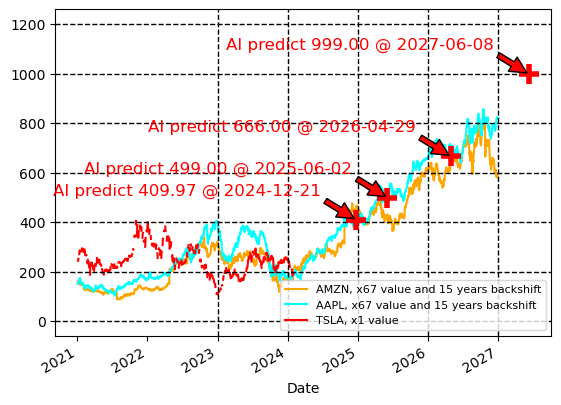

In [6]:
# Better graphical output

# Combine all back
a = pd.DataFrame(amazonMod)
b = a.join(appleMod)
compare = b.join(teslaMod)
ax = compare.plot.line(color={appleModName: "cyan", amazonModName: "orange", teslaModName: "red"})

# Draw lines for intermediate price points
for i in range(0, 1201, 200):
    plt.axhline(i, color='black', linestyle='--', lw=1)

# Draw line for years
plt.axvline('2023-01-01', color='black', linestyle='--',lw=1)
plt.axvline('2024-01-01', color='black', linestyle='--',lw=1)
plt.axvline('2025-01-01', color='black', linestyle='--',lw=1)
plt.axvline('2026-01-01', color='black', linestyle='--',lw=1)
plt.axvline('2027-01-01', color='black', linestyle='--',lw=1)

# Add points for AI guesses for price targets 
counter = 0
for target in Xtargets:
    
    time = Yp_data_plot[counter]
    
    #only print if prediction is at future time
    if time > pd.Timestamp.now():
            
        label = "AI predict {:.2f}".format(target) + " @ " + time.strftime('%Y-%m-%d')
        
        #label positions for plot
        timeLabel = time.floor('us') - pd.DateOffset(months=6) #offset for text label, flooring to remove convertion warning
        targetLabel = target + 100
        
        plt.scatter(time, target, marker='+', color='red', s=200, linewidths=4, zorder=3)
        
        plt.annotate(label, xy=(time, target), xytext=(timeLabel, targetLabel)
                 ,arrowprops=dict(facecolor='red', shrink=0.05)
                 ,color='red',fontsize=12,horizontalalignment='right')
    counter += 1

plt.legend(loc='lower right',fontsize=8)
    
# Plot and print to pdf and jpg
plt.savefig('TSLA22crashAIvsAMZNAPPL_in' + str(offsetByYears) + 'years@' + tendDate + '.pdf', dpi=300, bbox_inches='tight')
plt.savefig('TSLA22crashAIvsAMZNAPPL_in' + str(offsetByYears) + 'years@' + tendDate + '.png')

In [7]:
startDate = '2022-10-01'
endDate = '2023-02-28'
intervalDays = 5
tesla.loc[startDate:endDate:intervalDays]

Date
2022-10-03    242.399994
2022-10-10    222.960007
2022-10-17    219.350006
2022-10-24    211.250000
2022-10-31    227.539993
2022-11-07    197.080002
2022-11-14    190.949997
2022-11-21    167.869995
2022-11-29    180.830002
2022-12-06    179.820007
2022-12-13    160.949997
2022-12-20    137.800003
2022-12-28    112.709999
2023-01-05    110.339996
2023-01-12    123.559998
2023-01-20    133.419998
2023-01-27    177.899994
2023-02-03    189.979996
2023-02-10    196.889999
2023-02-17    208.309998
2023-02-27    207.630005
Name: TSLA, current value, dtype: float64